## Banking Hackathon

#### Loading required libraries

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
#from fancyimpute import KNN
from scipy import stats
from numpy import percentile
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,f1_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier

#### Reading the data

In [2]:
train = pd.read_csv('train_fNxu4vz.csv')
test = pd.read_csv('test_fjtUOL8.csv')


In [3]:
train.shape

(164309, 14)

In [4]:
test.shape

(109541, 13)

In [5]:
train.dtypes

Loan_ID                      int64
Loan_Amount_Requested       object
Length_Employed             object
Home_Owner                  object
Annual_Income              float64
Income_Verified             object
Purpose_Of_Loan             object
Debt_To_Income             float64
Inquiries_Last_6Mo           int64
Months_Since_Deliquency    float64
Number_Open_Accounts         int64
Total_Accounts               int64
Gender                      object
Interest_Rate                int64
dtype: object

#### Data Cleaning & Pre-Processing

#### Loan_Amount_Requested

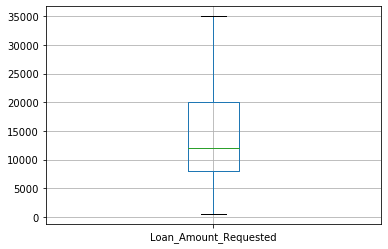

In [6]:
train['Loan_Amount_Requested'] = train['Loan_Amount_Requested'].str.replace(',','')
train['Loan_Amount_Requested'] = pd.to_numeric(train['Loan_Amount_Requested'])
train['Loan_Amount_Requested'].dtype

train.boxplot(column=['Loan_Amount_Requested'],return_type='axes')

In [7]:
test['Loan_Amount_Requested'] = test['Loan_Amount_Requested'].str.replace(',','')
test['Loan_Amount_Requested'] = pd.to_numeric(test['Loan_Amount_Requested'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000017B129AD508>]],
      dtype=object)

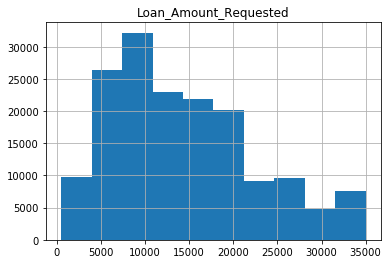

In [8]:
train.hist(column='Loan_Amount_Requested')

In [9]:
train['Loan_Amount_Requested'].isnull().sum()

0

In [10]:
test.shape

(109541, 13)

#### Length_Employed

In [11]:
train['Length_Employed'].value_counts()

10+ years    52915
2 years      14620
3 years      12974
< 1 year     12805
5 years      10814
1 year       10422
4 years       9784
7 years       9308
6 years       9094
8 years       7917
9 years       6285
Name: Length_Employed, dtype: int64

In [12]:
train['Length_Employed'].isnull().sum()

7371

In [13]:
train['Length_Employed'].fillna('10+ years',inplace=True)
test['Length_Employed'].fillna('10+ years',inplace=True)

Text(0.5, 0, 'Length Employed')

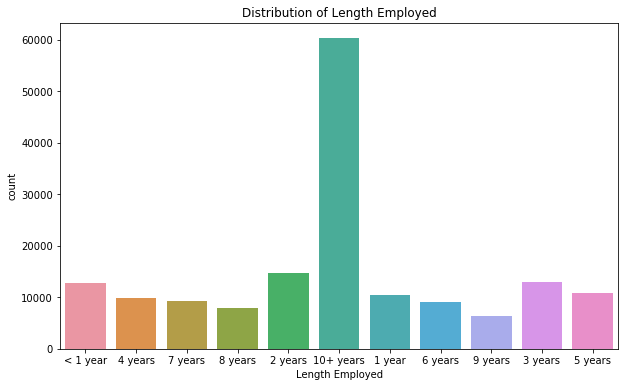

In [14]:
plt.figure(figsize=(10,6))
ax = sns.countplot(x="Length_Employed", data=train)
plt.title('Distribution of Length Employed')
plt.xlabel('Length Employed')

In [15]:
train['Length_Employed'] = train['Length_Employed'].str.replace('<','')
train['Length_Employed'] = train['Length_Employed'].str.replace('+','')
train['Length_Employed'] = train['Length_Employed'].str.replace('years','')
train['Length_Employed'] = train['Length_Employed'].str.replace('year','')
train['Length_Employed'] = train['Length_Employed'].str.strip()
train['Length_Employed'] = pd.to_numeric(train['Length_Employed'])

In [16]:
test['Length_Employed'] = test['Length_Employed'].str.replace('<','')
test['Length_Employed'] = test['Length_Employed'].str.replace('+','')
test['Length_Employed'] = test['Length_Employed'].str.replace('years','')
test['Length_Employed'] = test['Length_Employed'].str.replace('year','')
test['Length_Employed'] = test['Length_Employed'].str.strip()
test['Length_Employed'] = pd.to_numeric(test['Length_Employed'])

In [17]:
test.shape

(109541, 13)

#### Home_Owner

In [18]:
train['Home_Owner'].isnull().sum()

25349

In [19]:
train['Home_Owner'].fillna('Unknown',inplace=True)
test['Home_Owner'].fillna('Unknown',inplace=True)

In [20]:
train['Home_Owner'].value_counts()

Mortgage    70345
Rent        56031
Unknown     25349
Own         12525
Other          49
None           10
Name: Home_Owner, dtype: int64

In [21]:
train['Home_Owner'] = train['Home_Owner'].str.replace('Other','Unknown')
train['Home_Owner'] = train['Home_Owner'].str.replace('None','Unknown')

test['Home_Owner'] = test['Home_Owner'].str.replace('Other','Unknown')
test['Home_Owner'] = test['Home_Owner'].str.replace('None','Unknown')

In [22]:
train.isnull().sum() 

Loan_ID                        0
Loan_Amount_Requested          0
Length_Employed                0
Home_Owner                     0
Annual_Income              25102
Income_Verified                0
Purpose_Of_Loan                0
Debt_To_Income                 0
Inquiries_Last_6Mo             0
Months_Since_Deliquency    88379
Number_Open_Accounts           0
Total_Accounts                 0
Gender                         0
Interest_Rate                  0
dtype: int64

In [23]:
test.shape

(109541, 13)

#### Annual Income

In [24]:
train['Annual_Income'].dtype
train['Annual_Income'].mean()

73331.15943386467

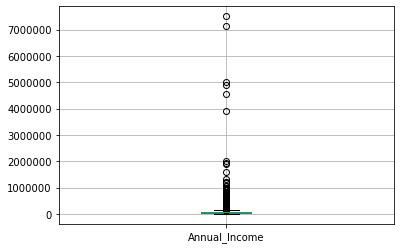

In [25]:
train.boxplot(column='Annual_Income',return_type='axes')

In [26]:
train['Annual_Income'].quantile([0.10, .90])

0.1     34000.0
0.9    120000.0
Name: Annual_Income, dtype: float64

In [27]:
# Removing outliers
train['Annual_Income'] = np.where(train['Annual_Income'] < 34000, 34000, train['Annual_Income'])
train['Annual_Income'] = np.where(train['Annual_Income'] > 120000,120000,train['Annual_Income'])

In [28]:
test['Annual_Income'] = np.where(test['Annual_Income'] < 34000, 34000, test['Annual_Income'])
test['Annual_Income'] = np.where(test['Annual_Income'] > 120000,120000,test['Annual_Income'])

In [29]:
test.shape

(109541, 13)

In [30]:
train['Annual_Income'].mean()

68639.93934026307

In [31]:
train['Annual_Income'].fillna(68639.94,inplace=True)
test['Annual_Income'].fillna(68639.94,inplace=True)

#### Income_Verified

In [32]:
train['Income_Verified'].value_counts()

VERIFIED - income           59421
VERIFIED - income source    53015
not verified                51873
Name: Income_Verified, dtype: int64

In [33]:
#Creating dummies
train = pd.get_dummies(train,columns=['Income_Verified'],drop_first=True)
test = pd.get_dummies(test,columns=['Income_Verified'],drop_first=True)

In [34]:
test.head()

,Loan_ID,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender,Income_Verified_VERIFIED - income source,Income_Verified_not verified
0,10164310,27500,10,Mortgage,120000.0,debt_consolidation,12.87,0,68.0,10,37,Male,0,0
1,10164311,26000,10,Unknown,110000.0,credit_card,11.37,0,NaN,6,23,Male,0,1
2,10164312,6075,1,Rent,75000.0,debt_consolidation,6.83,2,NaN,5,20,Male,0,0
3,10164313,12000,10,Mortgage,73000.0,debt_consolidation,7.76,0,NaN,6,8,Male,1,0
4,10164314,35000,1,Mortgage,120000.0,debt_consolidation,9.62,0,26.0,9,21,Male,0,1


In [35]:
test.shape

(109541, 14)

#### Purpose_Of_Loan

In [36]:
train['Purpose_Of_Loan'].value_counts()

debt_consolidation    97101
credit_card           36684
home_improvement       9269
other                  8346
major_purchase         3435
small_business         2392
car                    1885
medical                1541
moving                  974
vacation                837
wedding                 828
house                   773
renewable_energy        123
educational             121
Name: Purpose_Of_Loan, dtype: int64

In [37]:
train['Purpose_Of_Loan'] = np.where((train['Purpose_Of_Loan'] == 'major_purchase') | (train['Purpose_Of_Loan'] == 'small_business')|(train['Purpose_Of_Loan'] == 'car')|(train['Purpose_Of_Loan'] == 'medical')|(train['Purpose_Of_Loan'] == 'wedding')|(train['Purpose_Of_Loan'] == 'moving')|(train['Purpose_Of_Loan'] == 'vacation')|(train['Purpose_Of_Loan'] == 'house')|(train['Purpose_Of_Loan'] == 'educational')|(train['Purpose_Of_Loan'] == 'renewable_energy'),'other',train['Purpose_Of_Loan'])

In [38]:
test['Purpose_Of_Loan'] = np.where((test['Purpose_Of_Loan'] == 'major_purchase') | (test['Purpose_Of_Loan'] == 'small_business')|(test['Purpose_Of_Loan'] == 'car')|(test['Purpose_Of_Loan'] == 'medical')|(test['Purpose_Of_Loan'] == 'wedding')|(test['Purpose_Of_Loan'] == 'moving')|(test['Purpose_Of_Loan'] == 'vacation')|(test['Purpose_Of_Loan'] == 'house')|(test['Purpose_Of_Loan'] == 'educational')|(test['Purpose_Of_Loan'] == 'renewable_energy'),'other',test['Purpose_Of_Loan'])

In [39]:
train = pd.get_dummies(train,columns=['Purpose_Of_Loan'],drop_first=True)
test = pd.get_dummies(test,columns=['Purpose_Of_Loan'],drop_first=True)

In [40]:
train.head()

,Loan_ID,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate,Income_Verified_VERIFIED - income source,Income_Verified_not verified,Purpose_Of_Loan_debt_consolidation,Purpose_Of_Loan_home_improvement,Purpose_Of_Loan_other
0,10000001,7000,1,Rent,68000.00,18.37,0,NaN,9,14,Female,1,0,1,0,0,1
1,10000002,30000,4,Mortgage,68639.94,14.93,0,17.0,12,24,Female,3,0,0,1,0,0
2,10000003,24725,7,Mortgage,75566.40,15.88,0,NaN,12,16,Male,3,1,0,1,0,0
3,10000004,16000,1,Unknown,56160.00,14.34,3,NaN,16,22,Male,3,1,0,1,0,0
4,10000005,17000,8,Own,96000.00,22.17,1,NaN,19,30,Female,1,1,0,1,0,0


In [41]:
test.shape

(109541, 16)

#### Debt_To_Income

In [42]:
train['Debt_To_Income'].dtype

dtype('float64')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000017B150BAE08>]],
      dtype=object)

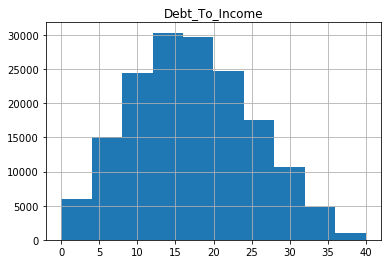

In [43]:
train.hist(column='Debt_To_Income')

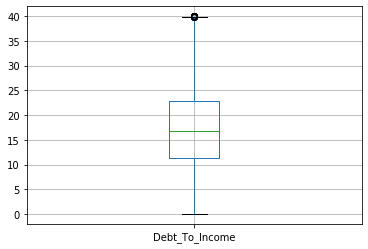

In [44]:
train.boxplot(column='Debt_To_Income',return_type='axes')

In [45]:
train['Debt_To_Income'].quantile([0.10, .90])

0.1     7.04
0.9    27.99
Name: Debt_To_Income, dtype: float64

In [46]:
# Removing outliers
train['Debt_To_Income'] = np.where(train['Debt_To_Income'] < 7.04, 7.04, train['Debt_To_Income'])
train['Debt_To_Income'] = np.where(train['Debt_To_Income'] > 27.99,27.99,train['Debt_To_Income'])

test['Debt_To_Income'] = np.where(test['Debt_To_Income'] < 7.04, 7.04, test['Debt_To_Income'])
test['Debt_To_Income'] = np.where(test['Debt_To_Income'] > 27.99,27.99,test['Debt_To_Income'])

In [47]:
test.shape

(109541, 16)

#### Inquiries_Last_6Mo

In [48]:
train['Inquiries_Last_6Mo'].dtype

dtype('int64')

In [49]:
train['Inquiries_Last_6Mo'].value_counts()

0    85665
1    46071
2    20297
3     8863
4     2278
5      772
6      335
7       20
8        8
Name: Inquiries_Last_6Mo, dtype: int64

In [50]:
train['Inquiries_Last_6Mo'] = np.where(train['Inquiries_Last_6Mo']>=8,7,train['Inquiries_Last_6Mo'])
test['Inquiries_Last_6Mo'] = np.where(test['Inquiries_Last_6Mo']>=8,7,test['Inquiries_Last_6Mo'])

In [51]:
test.shape

(109541, 16)

#### Months_Since_Deliquency

In [52]:
train['Months_Since_Deliquency'].dtype

dtype('float64')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000017B11F2BF88>]],
      dtype=object)

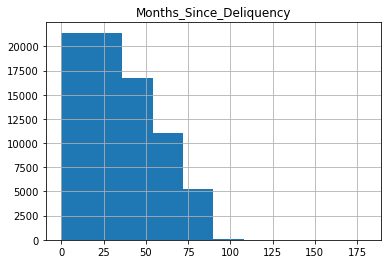

In [53]:
train.hist(column='Months_Since_Deliquency')

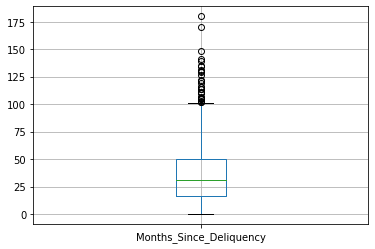

In [54]:
train.boxplot(column='Months_Since_Deliquency',return_type='axes')

In [55]:
train['Months_Since_Deliquency'].quantile([0.10, .90])

0.1     8.0
0.9    68.0
Name: Months_Since_Deliquency, dtype: float64

In [56]:
# Removing outliers
train['Months_Since_Deliquency'] = np.where(train['Months_Since_Deliquency'] < 8, 8, train['Months_Since_Deliquency'])
train['Months_Since_Deliquency'] = np.where(train['Months_Since_Deliquency'] > 68,68,train['Months_Since_Deliquency'])

test['Months_Since_Deliquency'] = np.where(test['Months_Since_Deliquency'] < 8, 8, test['Months_Since_Deliquency'])
test['Months_Since_Deliquency'] = np.where(test['Months_Since_Deliquency'] > 68,80,test['Months_Since_Deliquency'])

In [57]:
train.shape

(164309, 17)

In [58]:
train.isnull().sum()

Loan_ID                                         0
Loan_Amount_Requested                           0
Length_Employed                                 0
Home_Owner                                      0
Annual_Income                                   0
Debt_To_Income                                  0
Inquiries_Last_6Mo                              0
Months_Since_Deliquency                     88379
Number_Open_Accounts                            0
Total_Accounts                                  0
Gender                                          0
Interest_Rate                                   0
Income_Verified_VERIFIED - income source        0
Income_Verified_not verified                    0
Purpose_Of_Loan_debt_consolidation              0
Purpose_Of_Loan_home_improvement                0
Purpose_Of_Loan_other                           0
dtype: int64

In [59]:
train['Months_Since_Deliquency'].mean()

33.883590148821284

In [60]:
train['Months_Since_Deliquency'].fillna(33.88,inplace=True)
test['Months_Since_Deliquency'].fillna(33.88,inplace=True)

#### New Feature : Open_Accounts_Ratio

In [61]:
train['Open_Accounts_Ratio'] = train['Number_Open_Accounts'] / train['Total_Accounts']
test['Open_Accounts_Ratio'] = test['Number_Open_Accounts'] / test['Total_Accounts']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000017B12934488>]],
      dtype=object)

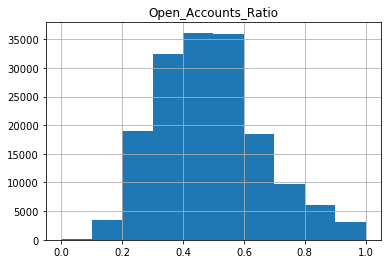

In [62]:
train.hist(column='Open_Accounts_Ratio')

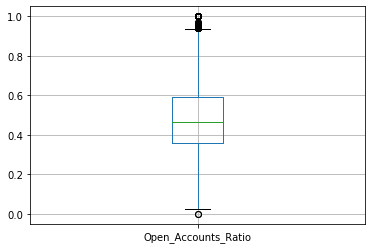

In [63]:
train.boxplot(column='Open_Accounts_Ratio')

In [64]:
train['Open_Accounts_Ratio'].quantile([0.1, .9])

0.1    0.277778
0.9    0.722222
Name: Open_Accounts_Ratio, dtype: float64

In [65]:
# Removing outliers
train['Open_Accounts_Ratio'] = np.where(train['Open_Accounts_Ratio'] < 0.277, 0.277, train['Open_Accounts_Ratio'])
train['Open_Accounts_Ratio'] = np.where(train['Open_Accounts_Ratio'] > 0.722,0.722,train['Open_Accounts_Ratio'])

test['Open_Accounts_Ratio'] = np.where(test['Open_Accounts_Ratio'] < 0.277, 0.277, test['Open_Accounts_Ratio'])
test['Open_Accounts_Ratio'] = np.where(test['Open_Accounts_Ratio'] > 0.722,0.722,test['Open_Accounts_Ratio'])

In [66]:
test.shape

(109541, 17)

#### Gender

In [67]:
train['Gender'].value_counts()

Male      117176
Female     47133
Name: Gender, dtype: int64

In [68]:
train = pd.get_dummies(train,columns=['Gender'],drop_first=True)
test = pd.get_dummies(test,columns=['Gender'],drop_first=True)

#### Home_Owner

In [69]:
train['Home_Owner'].value_counts()

Mortgage    70345
Rent        56031
Unknown     25408
Own         12525
Name: Home_Owner, dtype: int64

In [70]:
train = pd.get_dummies(train,columns=['Home_Owner'],drop_first=True)
test = pd.get_dummies(test,columns=['Home_Owner'],drop_first=True)

In [71]:
test.shape

(109541, 19)

#### Interest_Rate

In [72]:
train['Interest_Rate'].value_counts()

2    70580
3    59923
1    33806
Name: Interest_Rate, dtype: int64

In [73]:
train.head()

,Loan_ID,Loan_Amount_Requested,Length_Employed,Annual_Income,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Interest_Rate,Income_Verified_VERIFIED - income source,Income_Verified_not verified,Purpose_Of_Loan_debt_consolidation,Purpose_Of_Loan_home_improvement,Purpose_Of_Loan_other,Open_Accounts_Ratio,Gender_Male,Home_Owner_Own,Home_Owner_Rent,Home_Owner_Unknown
0,10000001,7000,1,68000.00,18.37,0,33.88,9,14,1,0,1,0,0,1,0.642857,0,0,1,0
1,10000002,30000,4,68639.94,14.93,0,17.00,12,24,3,0,0,1,0,0,0.500000,0,0,0,0
2,10000003,24725,7,75566.40,15.88,0,33.88,12,16,3,1,0,1,0,0,0.722000,1,0,0,0
3,10000004,16000,1,56160.00,14.34,3,33.88,16,22,3,1,0,1,0,0,0.722000,1,0,0,1
4,10000005,17000,8,96000.00,22.17,1,33.88,19,30,1,1,0,1,0,0,0.633333,0,1,0,0


In [74]:
train = train.drop(['Loan_ID','Number_Open_Accounts','Total_Accounts'],axis=1)
test_loan_id = test[['Loan_ID']]
test = test.drop(['Loan_ID','Number_Open_Accounts','Total_Accounts'],axis=1)

In [75]:
test.shape

(109541, 16)

#### Train_Test Split

In [76]:
y = train['Interest_Rate']
x = train.drop('Interest_Rate',axis=1)
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.15,stratify=y,random_state=42)

#### xgboost

In [77]:
classifier = xgb.XGBClassifier()
classifier.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [78]:
y_pred = classifier.predict(x_test)

In [79]:
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.5230656875076074


#### Random Forest

In [88]:
classifer2 = RandomForestClassifier()

In [89]:
classifer2.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [90]:
y_pred = classifer2.predict(x_test)

In [91]:
accuracy = accuracy_score(y_test,y_pred)
print(accuracy)

0.5057004909319592


#### Gradient Boosting

In [77]:
classifier3 = GradientBoostingClassifier()

In [78]:
classifier3.fit(x_train,y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [79]:
y_pred = classifier3.predict(x_test)

In [80]:
accuracy = accuracy_score(y_test,y_pred)
print(accuracy)

0.5275692782083012


#### AdaBoost

In [104]:
classifier4 = AdaBoostClassifier()

In [105]:
classifier4.fit(x_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

In [106]:
y_pred = classifier4.predict(x_test)

In [107]:
accuracy = accuracy_score(y_test,y_pred)
print(accuracy)

0.5214833448289853


#### Tuning Gradient Boosting

In [109]:
#Tuning learning rate and n_estimators
parm1 = {'learning_rate':[0.15,0.1,0.05,0.01,0.005],'n_estimators':[100,250,500,750,1000,1250]}

In [110]:
tuning = GridSearchCV(estimator =GradientBoostingClassifier(max_depth=4, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10), 
            param_grid = parm1, scoring='accuracy',n_jobs=4,iid=False, cv=5)

tuning.fit(x_train,y_train)

C:\Users\Biplab.Ghosal\AppData\Local\Continuum\anaconda3\envs\Uniphore\lib\site-packages\sklearn\model_selection\_search.py:825: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=4,
                                                  max_features='sqrt',
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
       

In [112]:
tuning.best_params_, tuning.best_score_

({'learning_rate': 0.05, 'n_estimators': 1250}, 0.5352565463217746)

#### Tuning Max_Depth

In [113]:
parm2 = {'max_depth':[2,3,4,5,6]}

In [114]:
tuning = GridSearchCV(estimator=GradientBoostingClassifier(learning_rate=0.05,n_estimators=1250,min_samples_split=2,min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10),
                     param_grid=parm2,scoring='accuracy',n_jobs = 4,iid=False,cv=5)

tuning.fit(x_train,y_train)

C:\Users\Biplab.Ghosal\AppData\Local\Continuum\anaconda3\envs\Uniphore\lib\site-packages\sklearn\model_selection\_search.py:825: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.05,
                                                  loss='deviance', max_depth=3,
                                                  max_features='sqrt',
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=1250,
                                                  n_iter_no_change=None,
     

In [115]:
tuning.best_params_, tuning.best_score_

({'max_depth': 4}, 0.5352565463217746)

#### Running the tuned model

In [117]:
model1 = GradientBoostingClassifier(learning_rate=0.05, n_estimators=1250,max_depth=4, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10)
model1.fit(x_train,y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=4,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=1250,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=10, subsample=1, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [118]:
y_pred = model1.predict(x_test)

In [119]:
accuracy = accuracy_score(y_test,y_pred)
print(accuracy)

0.5379153649531383


Text(0, 0.5, 'Feature Importance Score')

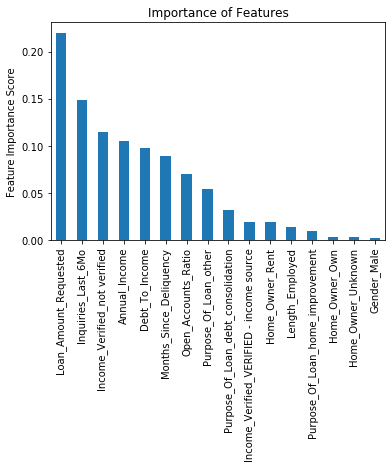

In [127]:
predictors=list(x_train)
feat_imp = pd.Series(model1.feature_importances_, predictors).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')

#### Tuning Min Sample Split & Min Samples Leaf

In [128]:
parm3 = {'min_samples_split':[2,4,6,8,10,20,40], 'min_samples_leaf':[1,3,5,7,9]}

In [129]:
tuning = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate=0.05, n_estimators=1250,max_depth=4, subsample=1,max_features='sqrt', random_state=10), 
            param_grid = parm3, scoring='accuracy',n_jobs=4,iid=False, cv=5)

tuning.fit(x_train,y_train)

C:\Users\Biplab.Ghosal\AppData\Local\Continuum\anaconda3\envs\Uniphore\lib\site-packages\sklearn\model_selection\_search.py:825: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.05,
                                                  loss='deviance', max_depth=4,
                                                  max_features='sqrt',
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=1250,
                                                  n_iter_no_change=None,
     

In [130]:
tuning.best_params_, tuning.best_score_

({'min_samples_leaf': 9, 'min_samples_split': 20}, 0.5358007094049986)

#### Tuning max_features

In [81]:
parm4 = {'max_features':[2,3,4,5,6,7]}

In [82]:
tuning = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate=0.05, n_estimators=1250,max_depth=4, min_samples_leaf=9,min_samples_split=20,subsample=1, random_state=10), 
            param_grid = parm4, scoring='accuracy',n_jobs=4,iid=False, cv=5)

tuning.fit(x_train,y_train)

C:\Users\Biplab.Ghosal\AppData\Local\Continuum\anaconda3\envs\Uniphore\lib\site-packages\sklearn\model_selection\_search.py:825: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.05,
                                                  loss='deviance', max_depth=4,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=9,
                                                  min_samples_split=20,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=1250,
                                                  n_iter_no_change=None,
      

In [83]:
tuning.best_params_, tuning.best_score_

({'max_features': 7}, 0.5369391644730546)

In [84]:
model2 = GradientBoostingClassifier(learning_rate=0.05, n_estimators=1250,max_depth=4, min_samples_split=20, min_samples_leaf=9, subsample=1,max_features=7, random_state=10)
model2.fit(x_train,y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=4,
                           max_features=7, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=9, min_samples_split=20,
                           min_weight_fraction_leaf=0.0, n_estimators=1250,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=10, subsample=1, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

#### Predicting on Test Set

In [85]:
y_test_pred = model2.predict(test)

In [86]:
y_test_pred

array([2, 2, 3, ..., 2, 3, 2], dtype=int64)

In [87]:
y_test_pred = pd.DataFrame(y_test_pred,columns=['Interest_Rate'])

In [88]:
y_test_pred

,Interest_Rate
0,2
1,2
2,3
3,2
4,2
...,...
109536,3
109537,2
109538,2
109539,3


In [89]:
final_predictions = pd.concat([test_loan_id,y_test_pred],axis=1)

In [90]:
final_predictions.head()

,Loan_ID,Interest_Rate
0,10164310,2
1,10164311,2
2,10164312,3
3,10164313,2
4,10164314,2


In [91]:
final_predictions.to_csv('Inital_Submission.csv',index=False)